In [1]:
using CUDA
CUDA.functional()

true

In [2]:
CUDA.versioninfo()

CUDA toolkit 11.7, artifact installation
NVIDIA driver 515.48.7, for CUDA 11.7
CUDA driver 11.7

Libraries: 
- CUBLAS: 11.10.1
- CURAND: 10.2.10
- CUFFT: 10.7.2
- CUSOLVER: 11.3.5
- CUSPARSE: 11.7.3
- CUPTI: 17.0.0
- NVML: 11.0.0+515.48.7
- CUDNN: 8.30.2 (for CUDA 11.5.0)
- CUTENSOR: 1.4.0 (for CUDA 11.5.0)

Toolchain:
- Julia: 1.8.1
- LLVM: 13.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0, 7.1, 7.2
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80, sm_86

1 device:
  0: NVIDIA GeForce RTX 2060 (sm_75, 5.278 GiB / 6.000 GiB available)


In [3]:
# Pkg.test("CUDA") 

In [3]:
using CSV
using DataFrames
using Pipe
using RCall

In [4]:
using MLJ
using MLJFlux
using Flux
using FeatureSelectors
using BSON: @save 

In [12]:
tp = @pipe CSV.File("./outlier_TP.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city"]))
tp.管理組織 = ifelse.(tp.有無管理組織 .== "有", 1, 0)
select!(tp, Not(["x1", "ifor"]))

return

In [13]:
nt = @pipe CSV.File("./outlier_NT.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city", "移轉層次", "總樓層數", "主要建材"]))
nt.管理組織 = ifelse.(nt.有無管理組織 .== "有", 1, 0)
select!(nt, Not(["鄉鎮市區", "ifor", "有無管理組織"]))
return

In [14]:
ks = @pipe CSV.File("./outlier_KS.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    DataFrames.select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city"]))
ks.管理組織 = ifelse.(ks.有無管理組織 .== "有", 1, 0)
select!(ks, Not(["鄉鎮市區", "ifor", "有無管理組織"]))
return

In [15]:
ty = @pipe CSV.File("./outlier_TY.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    DataFrames.select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city"]))
ty.管理組織 = ifelse.(ty.有無管理組織 .== "有", 1, 0)
select!(ty, Not(["x1", "ifor", "有無管理組織"]))
return

In [5]:
tn = @pipe CSV.File("./outlier_TN.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city", "移轉層次", "總樓層數", "主要建材"]))
tn.管理組織 = ifelse.(tn.有無管理組織 .== "有", 1, 0)
select!(tn, Not(["鄉鎮市區", "ifor", "有無管理組織"]))
return

In [17]:
tc = @pipe CSV.File("./outlier_TC.csv") |>
    DataFrame |>
    subset(_, :主要用途 => ByRow(x -> x == "住家用"), skipmissing = true) |>
    select(_, Not(["建物型態", "車位類別", "主要用途", "交易標的", "city", "移轉層次", "總樓層數", "主要建材"]))
tc.管理組織 = ifelse.(tc.有無管理組織 .== "有", 1, 0)
select!(tc, Not(["鄉鎮市區", "ifor", "有無管理組織"]))
return

In [6]:
function make_dummy_dataframe(x::AbstractVector)
    u = unique(x)
    m = Matrix{Bool}(undef, length(x), length(u))
    for i in eachindex(u)
        @. m[:, i] = x .== u[i]
    end
    df= DataFrame(m, u)
    return df
end

make_dummy_dataframe (generic function with 1 method)

In [7]:
# create mape function
function mape(yhat, ytest)
    n = length(ytest)
    diff = abs.(ytest .- yhat) ./ ytest
    mape = sum(diff) / n
    return mape
end

mape (generic function with 1 method)

In [8]:
# build the neural network layers
builder = MLJFlux.@builder begin
    init=Flux.glorot_uniform(rng)
    Chain(
        Dense(n_in, 64, sigmoid, init=init),
        Dense(64, 64, sigmoid, init=init),
        Dense(64, 32, sigmoid, init=init),
        Dense(32, 1, init=init))
end   

GenericBuilder(apply = #3)


In [9]:
# load regressor model
NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg = "MLJFlux"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/chanyu/.julia/packages/MLJModels/47nZM/src/loading.jl:159


import MLJFlux ✔


MLJFlux.NeuralNetworkRegressor

## Taipei

In [23]:
y, X = unpack(tp, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [54]:
tp_mape_list = Vector{Float64}()
for num in 1:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
    mape = round(mape(yhat , ytest), digits = 2) * 100
    append!(tp_mape_list, mape)
end
@show tp_mape_list
min_mape = minimum(tp_mape_list)
pos = findfirst(x -> x == min_mape, tp_mape_list) 
println("the optimal number of variables is => " , pos, 
    "\n with the mape => ", minimum(tp_mape_list)
)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info: Training machine(TransformedTargetModelDeterministic(model = NeuralNetworkRegressor(builder = GenericBuilder(apply = #7), …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Neu

1
mape(yhat, ytest) = 0.5077313131499505


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info: Training machine(TransformedTargetModelDeterministic(model = NeuralNetworkRegressor(builder = GenericBuilder(apply = #7), …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Train

2
mape(yhat, ytest) = 0.5178016466605184


┌ Info: Loss is 0.2421
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/buil

3
mape(yhat, ytest) = 0.5019728941410042


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


4
mape(yhat, ytest) = 0.13072442757063682


┌ Info: Loss is 0.01739
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/bui

5
mape(yhat, ytest) = 0.13912374532443247


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


6
mape(yhat, ytest) = 0.10572552302082759


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


7
mape(yhat, ytest) = 0.08501040526223422


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


8
mape(yhat, ytest) = 0.09680797601776865


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


9
mape(yhat, ytest) = 0.08396693417921457


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


10
mape(yhat, ytest) = 0.10530308076169402


┌ Info: Loss is 0.0147
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/buil

11
mape(yhat, ytest) = 0.12996793947351457


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


12
mape(yhat, ytest) = 0.17028555577025448


┌ Info: Loss is 0.01497
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/bui

13
mape(yhat, ytest) = 0.25869055150383213


┌ Info: Loss is 0.01231
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105


## New Taipei

In [19]:
y, X = unpack(nt, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [ ]:
#tp_mape_list = Vector{Float64}()
for num in 9:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
    #mape = round(mape(yhat , ytest), digits = 2) * 100
    #append!(tp_mape_list, mape)
end
#@show nt_mape_list
#min_mape = minimum(nt_mape_list)
#pos = findfirst(x -> x == min_mape, nt_mape_list) 
#println("the optimal number of variables is => " , pos, 
#    "\n with the mape => ", minimum(nt_mape_list)
#)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.97249423022797  sigma=477.07197615011313
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=146.2792845482691  sigma=85.27366502655931
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=66035.22598012481  sigma=26850.825167078634
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位移轉總面積_平方公尺    mu=11.672972699127497  sigma=14.884

In [ ]:
mape = [0.057276, 0.059324,  0.063943, 0.042782, 0.042699, 0.06579, 0.0549278,  0.07542171]

## KS

In [15]:
y, X = unpack(ks, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [ ]:
#ks_mape_list = Vector{Float64}()
for num in 8:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
   # mape = round(mape(yhat , ytest), digits = 2) * 100
   # append!(ks_mape_list, mape)
end
#@show ks_mape_list
#min_mape = minimum(nt_mape_list)
#pos = findfirst(x -> x == min_mape, ks_mape_list) 
#println("the optimal number of variables is => " , pos, 
#    "\n with the mape => ", minimum(ks_mape_list)
#)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=146.2792845482691  sigma=85.27366502655931
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=91.58537292428933  sigma=67.72297698517582
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :陽台面積    mu=9.998315789473684  sigma=8.237852208400833
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=66035.22598012481  sigma=26850.825167078634
└ @ 

8
mape(yhat, ytest) = 0.16659587590167896


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=146.2792845482691  sigma=85.27366502655931
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=91.58537292428933  sigma=67.72297698517582
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :陽台面積    mu=9.998315789473684  sigma=8.237852208400833
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=66035.22598012481  sigma=26850.825167078634
└ @ 

9
mape(yhat, ytest) = 0.15784398784943546


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=146.2792845482691  sigma=85.27366502655931
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=91.58537292428933  sigma=67.72297698517582
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :陽台面積    mu=9.998315789473684  sigma=8.237852208400833
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=66035.22598012481  sigma=26850.825167078634
└ @ 

In [ ]:
mape = [0.054577, 0.04917, 0.069613, 0.1665, 0.1578]

## TY

In [20]:
y, X = unpack(ty, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [21]:
for num in 5:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
end

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

5
mape(yhat, ytest) = 0.2534614040215257


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

6
mape(yhat, ytest) = 0.25201628354390615


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

7
mape(yhat, ytest) = 0.05563934809012574


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

8
mape(yhat, ytest) = 0.04854946566919671


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

9
mape(yhat, ytest) = 0.0763777813185599


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

10
mape(yhat, ytest) = 0.06731525879112045


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

11
mape(yhat, ytest) = 0.05681081280645584


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

12
mape(yhat, ytest) = 0.03128867052188108


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

13
mape(yhat, ytest) = 0.03424654981335112


## TC

In [22]:
y, X = unpack(tc, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [24]:
for num in 6:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
end

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

6
mape(yhat, ytest) = 0.3165300861477364


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

7
mape(yhat, ytest) = 0.09015884638421368


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

8
mape(yhat, ytest) = 0.07047775160218539


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

9
mape(yhat, ytest) = 0.07324454236150563


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

10
mape(yhat, ytest) = 0.07037110720288352


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

11
mape(yhat, ytest) = 0.09521016682998261


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

12
mape(yhat, ytest) = 0.08876320860170374


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

13
mape(yhat, ytest) = 0.11026957137463439


In [25]:
mape = [0.31097 0.31653 0.090158 0.07047 0.07324 0.070371 0.095210 0.08876 0.1102695]

LoadError: invalid redefinition of constant mape

## TN

In [11]:
y, X = unpack(tn, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);

In [12]:
for num in 5:13
    model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 20, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
    pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
    selector = UnivariateFeatureSelector(method = f_test, k = num)
    var = select_features(selector, X, y)
    train = select(X, var)
    test = select(Xtest, var)
    mach = machine(pipe, train, y)
    fit!(mach, verbosity=2)
    yhat = predict(mach, test)
    println(num)
    @show mape(yhat , ytest)
end

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

5
mape(yhat, ytest) = 0.4065721339298224


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

6
mape(yhat, ytest) = 0.41546906274959466


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

7
mape(yhat, ytest) = 0.07134753687509159


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

8
mape(yhat, ytest) = 0.07114929927353195


┌ Info: Loss is 0.1092
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/s

9
mape(yhat, ytest) = 0.0628757361594852


┌ Info: Loss is 0.0976
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/s

10
mape(yhat, ytest) = 0.06304196922551607


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

11
mape(yhat, ytest) = 0.05871120369662998


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

12
mape(yhat, ytest) = 0.1028387543554646


┌ Info: Loss is 0.08193
└ @ MLJFlux /home/chanyu/.julia/packages/MLJFlux/6XVNm/src/core.jl:105
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/

13
mape(yhat, ytest) = 0.08672547988123494


In [ ]:
 0.40657 0.4154 0.0713 0.071149 0.062875 0.0630419 0.058711 0.102838 0.08672

## Plot result

In [ ]:
using RCall

In [59]:
@rput tp_mape_list
#@rput nt_mape_list
#@rput ks_mape_list
#@rput ty_mape_list
#@rput tn_mape_list
#@rput tc_mape_list

13-element Vector{Float64}:
 50.77
 51.78
 50.19
 13.07
 13.91
 10.57
  8.5
  9.68
  8.39
 10.530000000000001
 12.989999999999998
 17.02
 25.86

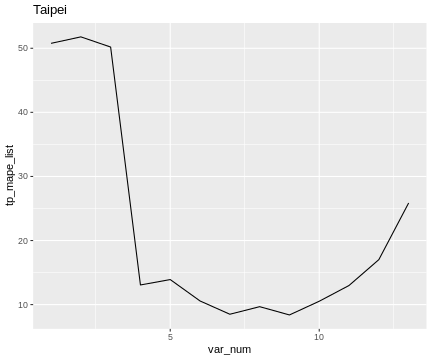

RObject{VecSxp}


In [61]:
R"""
library(ggplot2)
var_num = 1:13
df = data.frame(
    var_num, 
    tp_mape_list
)
ggplot(df, aes(var_num, tp_mape_list)) +
    geom_line() + 
    ggtitle("Taipei")
"""

## Optimal num of variables of taipei

In [64]:
#TP variable = """
# "建物移轉總面積平方公尺"
# "主建物面積"
# "車位總價元"
# "單價元平方公尺"
# "車位移轉總面積_平方公尺"
# "陽台面積"
# "建物現況格局_隔間"
# "土地移轉總面積平方公尺"
# "電梯"
#"""
y, X = unpack(tp, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 9
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = pearson_correlation, k = num)
UnivariateFeatureSelector(FeatureSelectors.pearson_correlation, num, nothing)
var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
tp_mach = machine(pipe, train, y)
fit!(tp_mach, verbosity=2)
yhat = predict(tp_mach, test)
println(num)
@show mape(yhat , ytest)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=127.21910820332158  sigma=90.64445462913302
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=78.63502868646201  sigma=49.0666244784124
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :車位總價元    mu=819312.6992450932  sigma=1.8714662454774848e6
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=212277.79387744976  sigma=89880.20518799321


9
mape(yhat, ytest) = 0.06546883643124886


0.06546883643124886

## Optimal num of variables of New Taipei

In [16]:
#NT variable = """
# "建物移轉總面積平方公尺"
# "主建物面積"
# "土地移轉總面積平方公尺"
# "單價元平方公尺"
# "車位總價元"
# "陽台面積"
# "附屬建物面積"
# "建物現況格局_衛"
# "電梯"
#"""
y, X = unpack(nt, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 9
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = f_test, k = num)
var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
nt_mach = machine(pipe, train, y)
fit!(nt_mach, verbosity=2)
yhat = predict(nt_mach, test)
println(num)
@show mape(yhat , ytest)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :建物移轉總面積平方公尺    mu=129.97568757192175  sigma=65.74066148225204
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :主建物面積    mu=76.40006041426928  sigma=40.985007172130345
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :土地移轉總面積平方公尺    mu=27.109964398734178  sigma=50.59853777484959
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :單價元平方公尺    mu=113966.81825373993  sigma=49979.042252

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:

 ## Optimal num of variables of KS

In [26]:
#KS variable = """
# "土地移轉總面積平方公尺"
# "建物移轉總面積平方公尺"
# "建物現況格局_房"
# "建物現況格局_廳"
# "建物現況格局_衛"
# "建物現況格局_隔間"
# "單價元平方公尺"
#"""
y, X = unpack(ks, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 7
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = f_test, k = num)
@show var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
ks_mach = machine(pipe, train, y)
fit!(ks_mach, verbosity=2)
yhat = predict(ks_mach, test)
println(num)
@show mape(yhat , ytest)

var = select_features(selector, X, y) = ["土地移轉總面積平方公尺", "建物移轉總面積平方公尺", "建物現況格局_房", "建物現況格局_廳", "建物現況格局_衛", "建物現況格局_隔間", "單價元平方公尺"]


LoadError: machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …) has not been trained.

## Optimal num of variables of TY

In [28]:
#TY variable = """
# "土地移轉總面積平方公尺"
# "建物移轉總面積平方公尺"
# "建物現況格局_房"
# "建物現況格局_廳"
# "建物現況格局_衛"
# "建物現況格局_隔間"
# "單價元平方公尺"
# "車位移轉總面積_平方公尺"
# "車位總價元"
# "主建物面積"
# "附屬建物面積"
# "陽台面積"
#"""
y, X = unpack(ty, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 12
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = f_test, k = num)
var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
ty_mach = machine(pipe, train, y)
fit!(ty_mach, verbosity=2)
yhat = predict(ty_mach, test)
println(num)
@show mape(yhat , ytest)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=36.23069025104402  sigma=156.41570146966643
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=143.4947141554265  sigma=71.55889991901205
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.8153410454567274  sigma=1.1885958239586545
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8494695915134642  sigma=0.629226

12
mape(yhat, ytest) = 0.04021653730494413


0.04021653730494413

## Optimal num of variables of TC

In [33]:
#TC variable = """
# "土地移轉總面積平方公尺"
# "建物移轉總面積平方公尺"
# "建物現況格局_房"
# "建物現況格局_廳"
# "建物現況格局_衛"
# "建物現況格局_隔間"
# "單價元平方公尺"
# "車位移轉總面積_平方公尺"
# "車位總價元"
#"""
y, X = unpack(tc, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 9
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = f_test, k = num)
var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
tc_mach = machine(pipe, train, y)
fit!(tc_mach, verbosity=2)
yhat = predict(tc_mach, test)
println(num)
@show mape(yhat , ytest)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=37.0970724414443  sigma=74.21362298020006
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=148.5280627916459  sigma=79.59615617334677
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=2.9714130385538895  sigma=1.7655609825125327
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8502242558782223  sigma=0.71970785

9
mape(yhat, ytest) = 0.0673461170194223


0.0673461170194223

## Optimal num of variables of TN

In [15]:
#TN variable = """
# "土地移轉總面積平方公尺"
# "建物移轉總面積平方公尺"
# "建物現況格局_房"
# "建物現況格局_廳"
# "建物現況格局_衛"
# "建物現況格局_隔間"
# "單價元平方公尺"
# "車位移轉總面積_平方公尺"
# "車位總價元"
#"""
y, X = unpack(tn, ==(:總價元), !=(:有無管理組織); rng = 123);
(X, Xtest), (y, ytest) = partition((X, y), 0.7, multi=true);
num = 9
model = NeuralNetworkRegressor(
        # loss = Flux.Losses.mse,
        builder = builder, 
        rng = 123, 
        epochs = 40, 
        batch_size = 1,
        acceleration = CUDALibs(), 
        optimiser_changes_trigger_retraining = true
    )  
pipe = Standardizer |> TransformedTargetModel(model, target=Standardizer)
selector = UnivariateFeatureSelector(method = f_test, k = num)
var = select_features(selector, X, y)
train = select(X, var)
test = select(Xtest, var)
tn_mach = machine(pipe, train, y)
fit!(tn_mach, verbosity=2)
yhat = predict(tn_mach, test)
println(num)
@show mape(yhat , ytest)

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/chanyu/.julia/packages/MLJBase/6ooqv/src/machines.jl:496
┌ Info: Features standarized: 
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:635
┌ Info:   :土地移轉總面積平方公尺    mu=57.19556453861165  sigma=75.17823966844671
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物移轉總面積平方公尺    mu=151.19788681349317  sigma=91.83190416828691
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_房    mu=3.33788681349317  sigma=2.5544524061657645
└ @ MLJModels /home/chanyu/.julia/packages/MLJModels/47nZM/src/builtins/Transformers.jl:646
┌ Info:   :建物現況格局_廳    mu=1.8436018957345972  sigma=0.72088996

9
mape(yhat, ytest) = 0.04968071860097995


0.04968071860097995

In [3]:
using MLJFlux
using BSON: @load

In [16]:
#@save "tp_model_final.bson" tp_mach
#@save "nt_model_final.bson" nt_mach
#@save "ks_model_final.bson" ks_mach
#@save "ty_model_final.bson" ty_mach
@save "tn_model_final.bson" tn_mach
#@save "tc_model_final.bson" tc_mach
